In [1]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
# Listing available GPUs
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Removing non-JPEG images from the "Cat" and "Dog" folders
import os
labels = ["daisy","dandelion","roses","sunflowers","tulips"]
num_skipped = 0
for folder_name in labels:
    folder_path = os.path.join("flower_photos",folder_name)
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path,file_name)

        try:
            fobj = open(file_path,"rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            os.remove(file_path)
print("Deleted %d images" % num_skipped)

Deleted 0 images


In [4]:
# Defining image size, batch size, and loading the dataset
image_size = (128,128)
batch_size = 16
train_ds,val_ds  = tf.keras.utils.image_dataset_from_directory(
    "flower_photos",
    validation_split=0.1,
    subset="both",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
    )

Found 3664 files belonging to 5 classes.
Using 3298 files for training.
Using 366 files for validation.


In [6]:
# Defining data augmentation techniques
data_augmentation = keras.Sequential(
    [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.6)
    ]
)

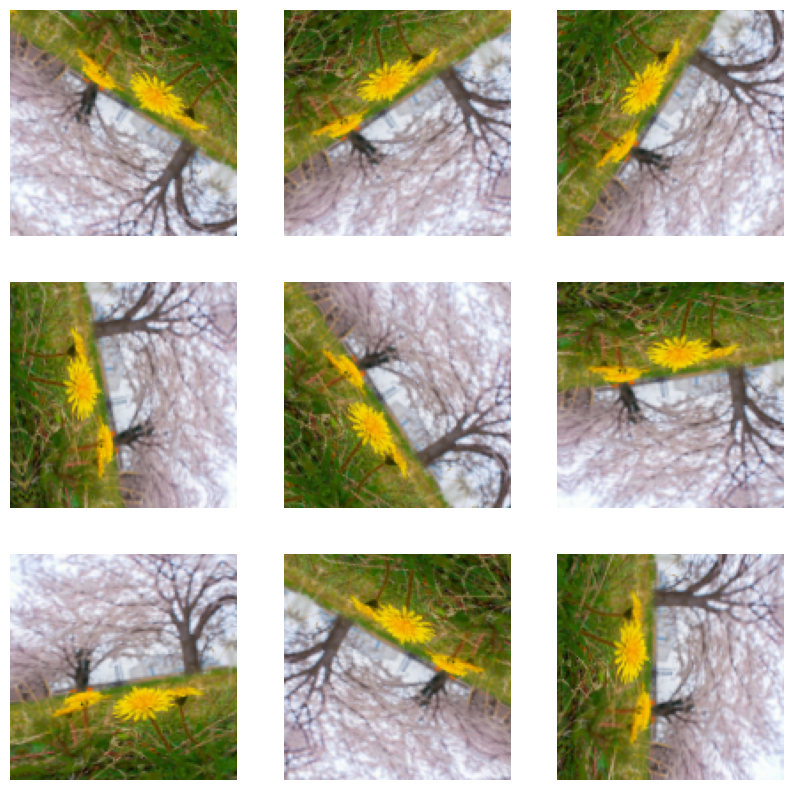

In [7]:
# Displaying augmented images
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
# Preprocessing input images
input_shape = (128,128,3)
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

In [9]:
#Apply 'data_augmentation' to the training image
train_ds = train_ds.map(
    lambda img,label:(data_augmentation(img),label),
    num_parallel_calls = tf.data.AUTOTUNE
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [10]:
#We have a multi-class dataset, so we have to apply one-hot encoding
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, len(labels))))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, len(labels))))

In [11]:
#Creating the model architecture
#I used the technique of transfer learning and its application of EfficientNetV2S. There are a few more application/model but with my RTX 3050 gpu, I've used this for the best validation accuracy. 
def make_model(input_shape,num_classes):
    base_model = keras.applications.EfficientNetV2S(include_top=False,weights="imagenet",input_shape=input_shape)
    model = base_model.output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)
    model = tf.keras.layers.Dropout(0.5)(model)
    model = tf.keras.layers.Dense(units=num_classes,activation="softmax")(model)    
    model = tf.keras.models.Model(inputs=base_model.input,outputs = model)

    return model

In [12]:
input_shape = (128,128,3)
classes = len(labels)
model = make_model(input_shape=input_shape,num_classes=classes)

In [13]:
# Create lists to track loss and accuracy history before compiling the model
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

# Track loss and accuracy metrics during the training process
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_loss.append(logs["loss"])
        train_accuracy.append(logs["accuracy"])
        val_loss.append(logs["val_loss"])
        val_accuracy.append(logs["val_accuracy"])

In [14]:
# Compiling and training the model
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("weightsforflower7optimized/save_path_{epoch}.keras",save_best_only=True),
    CustomCallback()
]
model.compile(optimizer = "Adam",
        loss = 'categorical_crossentropy',
        metrics = ["accuracy"]
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data = val_ds
)

Epoch 1/25
207/207 [==============================] - 54s 194ms/step - loss: 0.7994 - accuracy: 0.7083 - val_loss: 0.4649 - val_accuracy: 0.8169
Epoch 2/25
207/207 [==============================] - 38s 181ms/step - loss: 0.6202 - accuracy: 0.7814 - val_loss: 0.5310 - val_accuracy: 0.7978
Epoch 3/25
207/207 [==============================] - 37s 180ms/step - loss: 0.5244 - accuracy: 0.8123 - val_loss: 1.2014 - val_accuracy: 0.7623
Epoch 4/25
207/207 [==============================] - 36s 172ms/step - loss: 0.4599 - accuracy: 0.8393 - val_loss: 0.3353 - val_accuracy: 0.8934
Epoch 5/25
207/207 [==============================] - 27s 128ms/step - loss: 0.4303 - accuracy: 0.8487 - val_loss: 0.3891 - val_accuracy: 0.8552
Epoch 6/25
207/207 [==============================] - 28s 132ms/step - loss: 0.3738 - accuracy: 0.8578 - val_loss: 0.2950 - val_accuracy: 0.8934
Epoch 7/25
207/207 [==============================] - 27s 127ms/step - loss: 0.3362 - accuracy: 0.8817 - val_loss: 0.3170 - val_ac

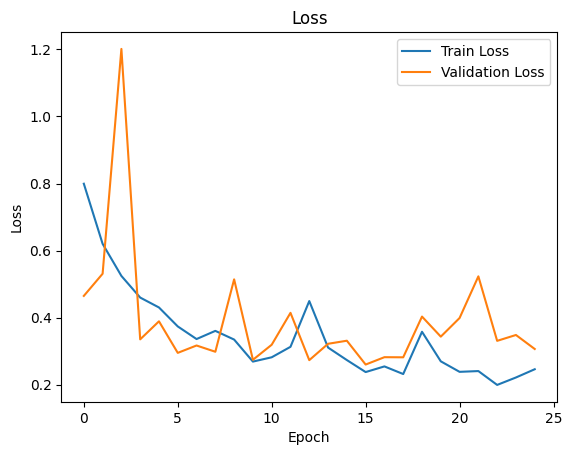

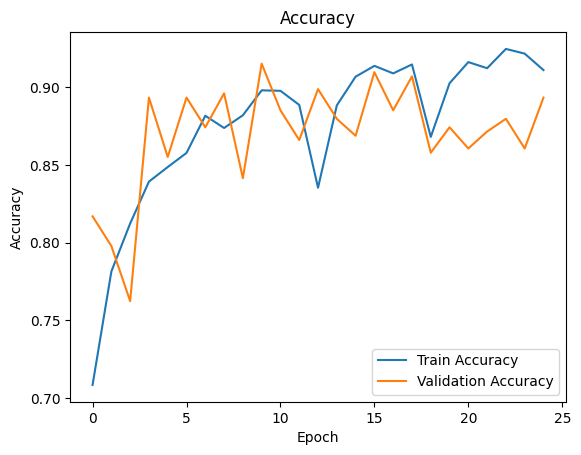

In [36]:
import matplotlib.pyplot as plt

# Plot the loss curve
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curve
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


12/12 [==============================] - 2s 47ms/step


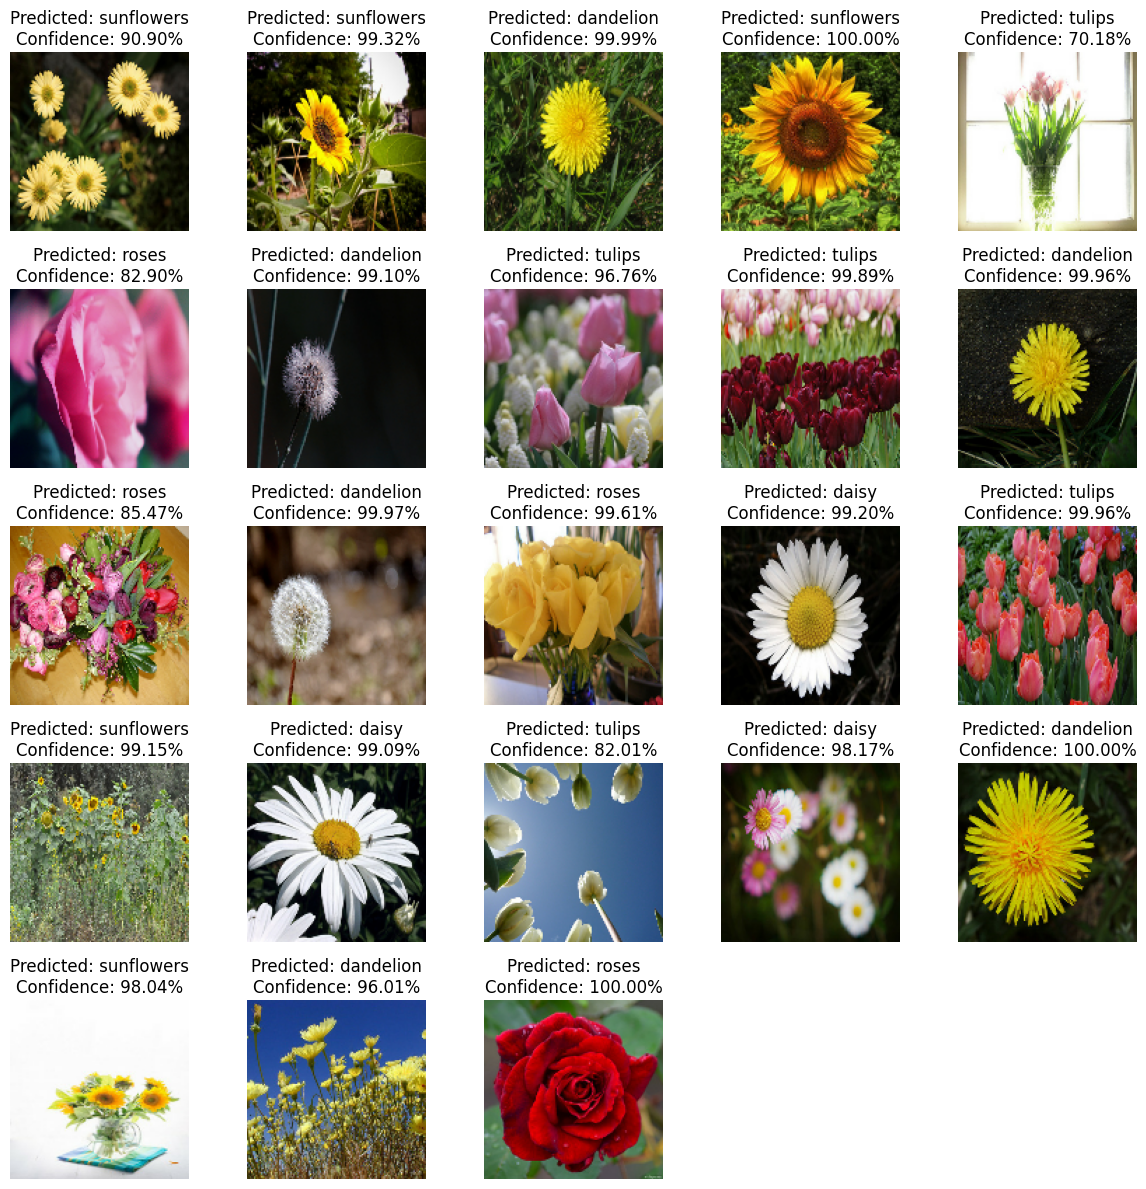

In [17]:
import random
import numpy as np
import matplotlib.pyplot as plt
# Create a dictionary to map integer labels to string names
labels_map = {
    0: "daisy",
    1: "dandelion",
    2: "roses",
    3: "sunflowers",
    4: "tulips",
}

# Convert the validation dataset to a list
val_ds_list = list(val_ds)

# Select 23 random images from the validation dataset
random_images = random.sample(val_ds_list, 23)

images = []
labels = []
for image, label in random_images:
    images.append(image)
    labels.append(label)

images = tf.concat(images, axis=0)

# Make predictions on the selected images
predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)
confidences = np.max(predictions, axis=1)

# Visualize the images and predictions
plt.figure(figsize=(12, 12))
for i in range(23):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"Predicted: {labels_map[predicted_labels[i]]}\nConfidence: {confidences[i]:.2%}")
    plt.axis("off")
    
plt.tight_layout()
plt.show()
